For **ST-ResNet**, it leverages sequence data (sale_cnt) and external factors (shop_id, item_id, price).
* input 1: [sale_cnt seq], shape = (N,step)
* input 2: [shop_id, item_id, price], shape = (N,3)

This is a version of ST-ResNet applied on 1D Time-Series Prediction, so the model structure is simplified.

In [8]:
# Read data and aggregate into monthly sale_cnt and avg_price of shop_item

import pandas as pd

train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
# columns: date, date_block_num, shop_id, item_id, item_price, item_cnt_day
train_monthly_df = train_df.groupby(['date_block_num','shop_id','item_id']).agg(sale_cnt_month=('item_cnt_day','sum'), avg_price_month=('item_price','mean')).reset_index()
train_monthly_df['shop_item'] = train_monthly_df['shop_id'].astype('string') + '-' + train_monthly_df['item_id'].astype('string')
shop_item_list = pd.unique(train_monthly_df['shop_item'])
shop_id_list = pd.unique(train_monthly_df['shop_id'])
item_id_list = pd.unique(train_monthly_df['item_id'])

print("count of shop_item:",len(shop_item_list))
print('------')
print('count of shop_id:', len(shop_id_list))
print('min shop_id:', min(shop_id_list))
print('max shop id:', max(shop_id_list))
print('------')
print('count item_id:', len(item_id_list))
print('min item_id:', min(item_id_list))
print('max item id:', max(item_id_list))
train_monthly_df

count of shop_item: 424124
------
count of shop_id: 60
min shop_id: 0
max shop id: 59
------
count item_id: 21807
min item_id: 0
max item id: 22169


,date_block_num,shop_id,item_id,sale_cnt_month,avg_price_month,shop_item
0,0,0,32,6.0,221.0,0-32
1,0,0,33,3.0,347.0,0-33
2,0,0,35,1.0,247.0,0-35
3,0,0,43,1.0,221.0,0-43
4,0,0,51,2.0,128.5,0-51
...,...,...,...,...,...,...
1609119,33,59,22087,6.0,119.0,59-22087
1609120,33,59,22088,2.0,119.0,59-22088
1609121,33,59,22091,1.0,179.0,59-22091
1609122,33,59,22100,1.0,629.0,59-22100


In [9]:
# get the "sale_cnt sequences" of each "shop_item"
## get (data_seq_dict) and (data_seq_array)

import numpy as np

data_seq_dict = {}
for shop_item in shop_item_list:
    data_seq_dict[shop_item] = [0.0 for i in range(0,34)]
for _, row in train_monthly_df.iterrows():
    data_seq_dict[row['shop_item']][int(row['date_block_num'])] = row['sale_cnt_month']

data_seq_array = np.array(list(data_seq_dict.values()))
print("The sale_cnt sequences of shop-item:")
print(data_seq_array.shape)  # (424124, 34)
print(data_seq_array)

The sale_cnt sequences of shop-item:
(424124, 34)
[[ 6. 10.  0. ...  0.  0.  0.]
 [ 3.  3.  0. ...  0.  0.  0.]
 [ 1. 14.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  2.]
 [ 0.  0.  0. ...  0.  0.  1.]]


In [10]:
# get the "last price" of each "shop_item" as the future price
## shopitem_price_dict

import random

shopitem_price_dict = {}
# record price and max date_block_num of each shop_item
for _, row in train_monthly_df.iterrows():
    if row['shop_item'] not in shopitem_price_dict.keys():
        shopitem_price_dict[row['shop_item']] = [row['avg_price_month'], row['date_block_num'], 1]
    else:
        if row['date_block_num'] > shopitem_price_dict[row['shop_item']][1]:
            shopitem_price_dict[row['shop_item']] = [row['avg_price_month'], row['date_block_num'], 1]
        if row['date_block_num'] == shopitem_price_dict[row['shop_item']][1]:
            entry = shopitem_price_dict[row['shop_item']]
            count = entry[2] + 1
            price = (entry[0] * entry[2] + row['avg_price_month']) / count
            shopitem_price_dict[row['shop_item']] = [price, row['date_block_num'], count]
# remove date_block_num and count in the dict to only keep [shop_item, avg_price_month]
for k,v in shopitem_price_dict.items():
    shopitem_price_dict[k] = v[0]

print("The last price of shop-item:")
print(len(shopitem_price_dict))  # should be equal to count of short_item
print(shop_item_list[random.randint(0,len(shop_item_list))], ":", shopitem_price_dict[shop_item_list[random.randint(0,len(shop_item_list))]])  # printout a random sample

The last price of shop-item:
424124
41-14678 : 79.2


In [11]:
# get the avg "sale_cnt sequences" of each "item" as default
# In case the shop_item in test dataset does not appear in training dataset, 
# we use the "item avg sale_cnt sequence" as default.
## get (item_seq_dict)

item_seq_dict = {}
item_seq_num_dict = {}
# make sum
for k, v in data_seq_dict.items():
    item = k.split('-')[1]
    if item not in item_seq_dict.keys():
        item_seq_dict[item] = v
        item_seq_num_dict[item] = 1
    else:
        item_seq_dict[item] = [i+j for i, j in zip(item_seq_dict[item], v)]
        item_seq_num_dict[item] += 1
# make average
for item in item_seq_dict.keys():
    item_seq_dict[item] = [element / item_seq_num_dict[item] for element in item_seq_dict[item]]

print("The sale_cnt sequences of item:")
print(np.array(list(item_seq_dict.values())).shape)  # (num_item, steps)=(21807, 34)
print(np.array(list(item_seq_dict.values())))

The sale_cnt sequences of item:
(21807, 34)
[[5.64150943 3.9245283  3.35849057 ... 0.56603774 0.35849057 0.41509434]
 [1.12962963 0.72222222 0.59259259 ... 0.25925926 0.2962963  0.2962963 ]
 [1.85714286 2.83333333 0.54761905 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [12]:
# get the "last price" of each "item" as the future price
## item_price_dict

item_price_dict = {}  # {item_id: [avg_price, current_max_date_block_num, cnt]}
# record prices and max date_block_num of each item
for _, row in train_monthly_df.iterrows():
    if row['item_id'] not in item_price_dict.keys():
        item_price_dict[row['item_id']] = [row['avg_price_month'], row['date_block_num'], 1]
    else:
        if row['date_block_num'] > item_price_dict[row['item_id']][1]:
            item_price_dict[row['item_id']] = [row['avg_price_month'], row['date_block_num'], 1]
        if row['date_block_num'] == item_price_dict[row['item_id']][1]:
            cnt = item_price_dict[row['item_id']][2] + 1
            price = (item_price_dict[row['item_id']][0] * item_price_dict[row['item_id']][2] + row['avg_price_month']) / cnt
            item_price_dict[row['item_id']] = [price, row['date_block_num'], cnt]
for k,v in item_price_dict.items():
    item_price_dict[k] = v[0]

print("The last price of shop-item:")
print(len(item_price_dict))  # should be equal to count of item_id
print(item_id_list[random.randint(0,len(item_id_list))], ":", item_price_dict[item_id_list[random.randint(0,len(item_id_list))]])  # printout a random sample

The last price of shop-item:
21807
14189 : 169.0


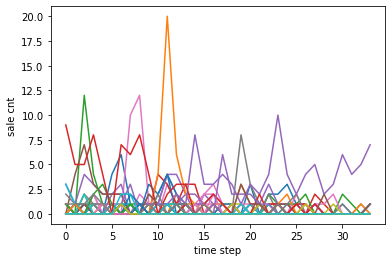

In [13]:
# plot curve

import matplotlib.pyplot as plt

row_random_array = np.arange(data_seq_array.shape[0])
np.random.shuffle(row_random_array)
row_random = data_seq_array[row_random_array][0:100,:]
for seq in row_random:
    plt.plot(seq)
plt.xlabel('time step')
plt.ylabel('sale cnt')
plt.show()

In [14]:
# Data Preprocess

import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K


# parameter
ITEM_VOCAB_LEN = 1000

# OneHotEncoder of shop_id, item_id 
feature_encoder = OneHotEncoder(handle_unknown='ignore')
shop_item_mod = np.array(train_monthly_df[['shop_id', 'item_id']])
shop_item_mod[:,1] = shop_item_mod[:,1] % ITEM_VOCAB_LEN
feature_encoder.fit(shop_item_mod)
# print(one_hot_encoder.categories_)

# Scaler of price
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.fit([[i] for i in train_monthly_df['avg_price_month'].tolist()])

# Scaler of sale_cnt_seq, feature_range=(-1,1)
max_sale_cnt = max(train_monthly_df['sale_cnt_month'])
min_sale_cnt = min(train_monthly_df['sale_cnt_month'])
class SaleCntScaler():
    def __init__(self):
        self.fearure_range_min = -1
        self.fearure_range_max = 1
    def scale(self, x):
        return (x - min_sale_cnt) / (max_sale_cnt - min_sale_cnt) * (self.fearure_range_max - self.fearure_range_min) + self.fearure_range_min
    def descale(self, x):
        return (x - self.fearure_range_min) / (self.fearure_range_max - self.fearure_range_min) * (max_sale_cnt - min_sale_cnt) + min_sale_cnt
sale_cnt_scaler = SaleCntScaler()


# Split X and Y
X = []
Y = []
for k,v in data_seq_dict.items():
    shop_vec = int(k.split('-')[0])
    item_vec = int(k.split('-')[1]) % ITEM_VOCAB_LEN
    static_vec = feature_encoder.transform([[shop_vec, item_vec]]).toarray().reshape((-1,))
    price_vec = price_scaler.transform([[shopitem_price_dict[k]]]).reshape((-1,))
    ext_vec = np.concatenate([static_vec, price_vec])
    sale_cnt_seq = np.array([sale_cnt_scaler.scale(i) for i in v])
    X.append([ext_vec, sale_cnt_seq[:-1]])
    Y.append(sale_cnt_seq[-1])
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1)
X_train_ext = np.array([x[0] for x in X_train])
X_train_seq = np.array([x[1] for x in X_train])
Y_train = np.array(Y_train)
X_val_ext = np.array([x[0] for x in X_val])
X_val_seq = np.array([x[1] for x in X_val])
Y_val = np.array(Y_val)

print("X_train_ext:")
print(X_train_ext)
print("X_train_seq:")
print(X_train_seq)
print("Y_train:")
print(Y_train)
print("X_val_ext:")
print(X_val_ext)
print("X_val_seq:")
print(X_val_seq)
print("Y_val:")
print(Y_val)

X_train_ext:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.67303354e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.06227942e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.13289857e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.94463983e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.13614554e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.61994333e-03]]
X_train_seq:
[[-0.98065934 -0.98065934 -0.98065934 ... -0.98065934 -0.98065934
  -0.98065934]
 [-0.98065934 -0.98065934 -0.97978022 ... -0.98065934 -0.98065934
  -0.98065934]
 [-0.98065934 -0.98065934 -0.98065934 ... -0.98065934 -0.98065934
  -0.98065934]
 ...
 [-0.98065934 -0.98065934 -0.98065934 ... -0.98065934 -0.98065934
  -0.98065934]
 [-0.98065934 -0.97978022 -0.98065934 ... -0.

In [15]:
# Model Parameters
from math import floor

STEPS = len(X_train_seq[0])
EXT_DIM = len(X_train_ext[0])
CLOSENESS_LEN = 3
PERIOD_LEN = floor((STEPS - CLOSENESS_LEN)/12)*12
TREND_LEN = floor((STEPS - CLOSENESS_LEN)/12)*12
RES_UNIT_NUM = 4

In [16]:
# ST-ResNet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from math import log
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import feature_column
from tensorflow.nn import relu
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error

class ResUnit(tf.keras.layers.Layer):
    def __init__(self,name=None):
        super(ResUnit, self).__init__(name=name)
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.relu = Activation('relu')
        self.conv1 = Conv1D(filters=4,kernel_size=1,strides=1,padding='same')
        self.conv2 = Conv1D(filters=4,kernel_size=1,strides=1,padding='same')
        self.add = Add()
    def call(self, input):
        output = self.bn1(input)
        output = self.relu(output)
        output = self.conv1(output)
        output = self.bn2(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.add([input, output])
        return output

class HadamardProductLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HadamardProductLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=input_shape[1:],  # omit the batch_size dimension
                                      trainable=True)
    def call(self, input):
        return tf.multiply(input, self.kernel)
    
    

# model
input_seq_vec = Input(name='input_seq', shape = (STEPS,))  # (N, steps）

# Closeness
## closeness data preparation
closeness_input_vec = Lambda(lambda x: tf.slice(x,(0,STEPS-CLOSENESS_LEN),(-1,CLOSENESS_LEN)))(input_seq_vec)  # (N, closeness_len)
closeness_input_vec = Reshape((1,-1))(closeness_input_vec)  # (N, 1, closeness_len), analog with (N, Width*Height, Channel) in CNN, steps is channel
## closeness component
closeness_vec = Conv1D(filters=4,kernel_size=1,strides=1,padding='same',activation='relu',name='closeness_conv1')(closeness_input_vec)  # (N, 1, filters)
for i in range(0,RES_UNIT_NUM):
    closeness_vec = ResUnit()(closeness_vec)
closeness_vec = Conv1D(filters=1,kernel_size=1,strides=1,padding='same',activation='relu',name='closeness_conv2')(closeness_vec)  # (N, 1, filters)

# Period
## period data preparation
period_input_vec = Lambda(lambda x: tf.slice(x,(0,STEPS-PERIOD_LEN-CLOSENESS_LEN),(-1,PERIOD_LEN)))(input_seq_vec)  # (N, period_len)
period_input_vec = Reshape((1,-1))(period_input_vec)  # (N, 1, period_len), analog with (N, Width*Height, Channel) in CNN, steps is channel
## period component
period_vec = Conv1D(filters=4,kernel_size=1,strides=1,padding='same',activation='relu',name='period_conv1')(period_input_vec)  # (N, 1, filters)
for i in range(0,RES_UNIT_NUM):
    period_vec = ResUnit()(period_vec)
period_vec = Conv1D(filters=1,kernel_size=1,strides=1,padding='same',activation='relu',name='period_conv2')(period_vec)  # (N, 1, filters)

# Trend
## trend data preparation
trend_input_vec = Lambda(lambda x: tf.slice(x,(0,0),(-1,TREND_LEN)))(input_seq_vec)  # (N, trend_len)
trend_input_vec = Reshape((1,-1))(trend_input_vec)  # (N, 1, trend_len), analog with (N, Width*Height, Channel) in CNN, steps is channel
## trend component
trend_vec = Conv1D(filters=4,kernel_size=1,strides=1,padding='same',activation='relu',name='trend_conv1')(trend_input_vec)  # (N, 1, filters)
for i in range(0,RES_UNIT_NUM):
    trend_vec = ResUnit()(trend_vec)
trend_vec = Conv1D(filters=1,kernel_size=1,strides=1,padding='same',activation='relu',name='trend_conv2')(trend_vec)  # (N, 1, filters)

# Parametric-matrix-based Fusion
closeness_vec = HadamardProductLayer()(closeness_vec)  # (N, 1, filters)
period_vec = HadamardProductLayer()(period_vec)  # (N, 1, filters)
trend_vec = HadamardProductLayer()(trend_vec)  # (N, 1, filters)
res_vec = Add()([closeness_vec, period_vec, trend_vec])  # (N, 1, filters)
res_vec = Flatten()(res_vec)  # (N, 1)

# External factors
input_ext_vec = Input(name='input_ext', shape = (EXT_DIM,))  # (N, ext_dim)
ext_vec = Dense(10, activation='relu', name='embed_Dense')(input_ext_vec)
ext_vec = Dense(1, activation=None, name='external_Dense')(ext_vec)

# Fusion with external factors
output_vec = Add()([res_vec, ext_vec])
output_vec = Activation('tanh')(output_vec)

model = Model(inputs=[input_seq_vec,input_ext_vec], outputs=[output_vec])
model.compile(loss=mean_squared_error, optimizer=Adam(learning_rate=0.01))
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01,
                                              verbose=1, mode='min', patience=3,
                                              restore_best_weights=True)]

history = model.fit(x={'input_seq': X_train_seq, 'input_ext': X_train_ext}, 
                    y=Y_train, 
                    validation_data=({'input_seq':X_val_seq,'input_ext':X_val_ext}, Y_val), 
                    epochs=10, 
                    batch_size=1024*1024,
                    callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq (InputLayer)          [(None, 33)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 3)            0           input_seq[0][0]                  
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 24)           0           input_seq[0][0]                  
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 24)           0           input_seq[0][0]                  
______________________________________________________________________________________________

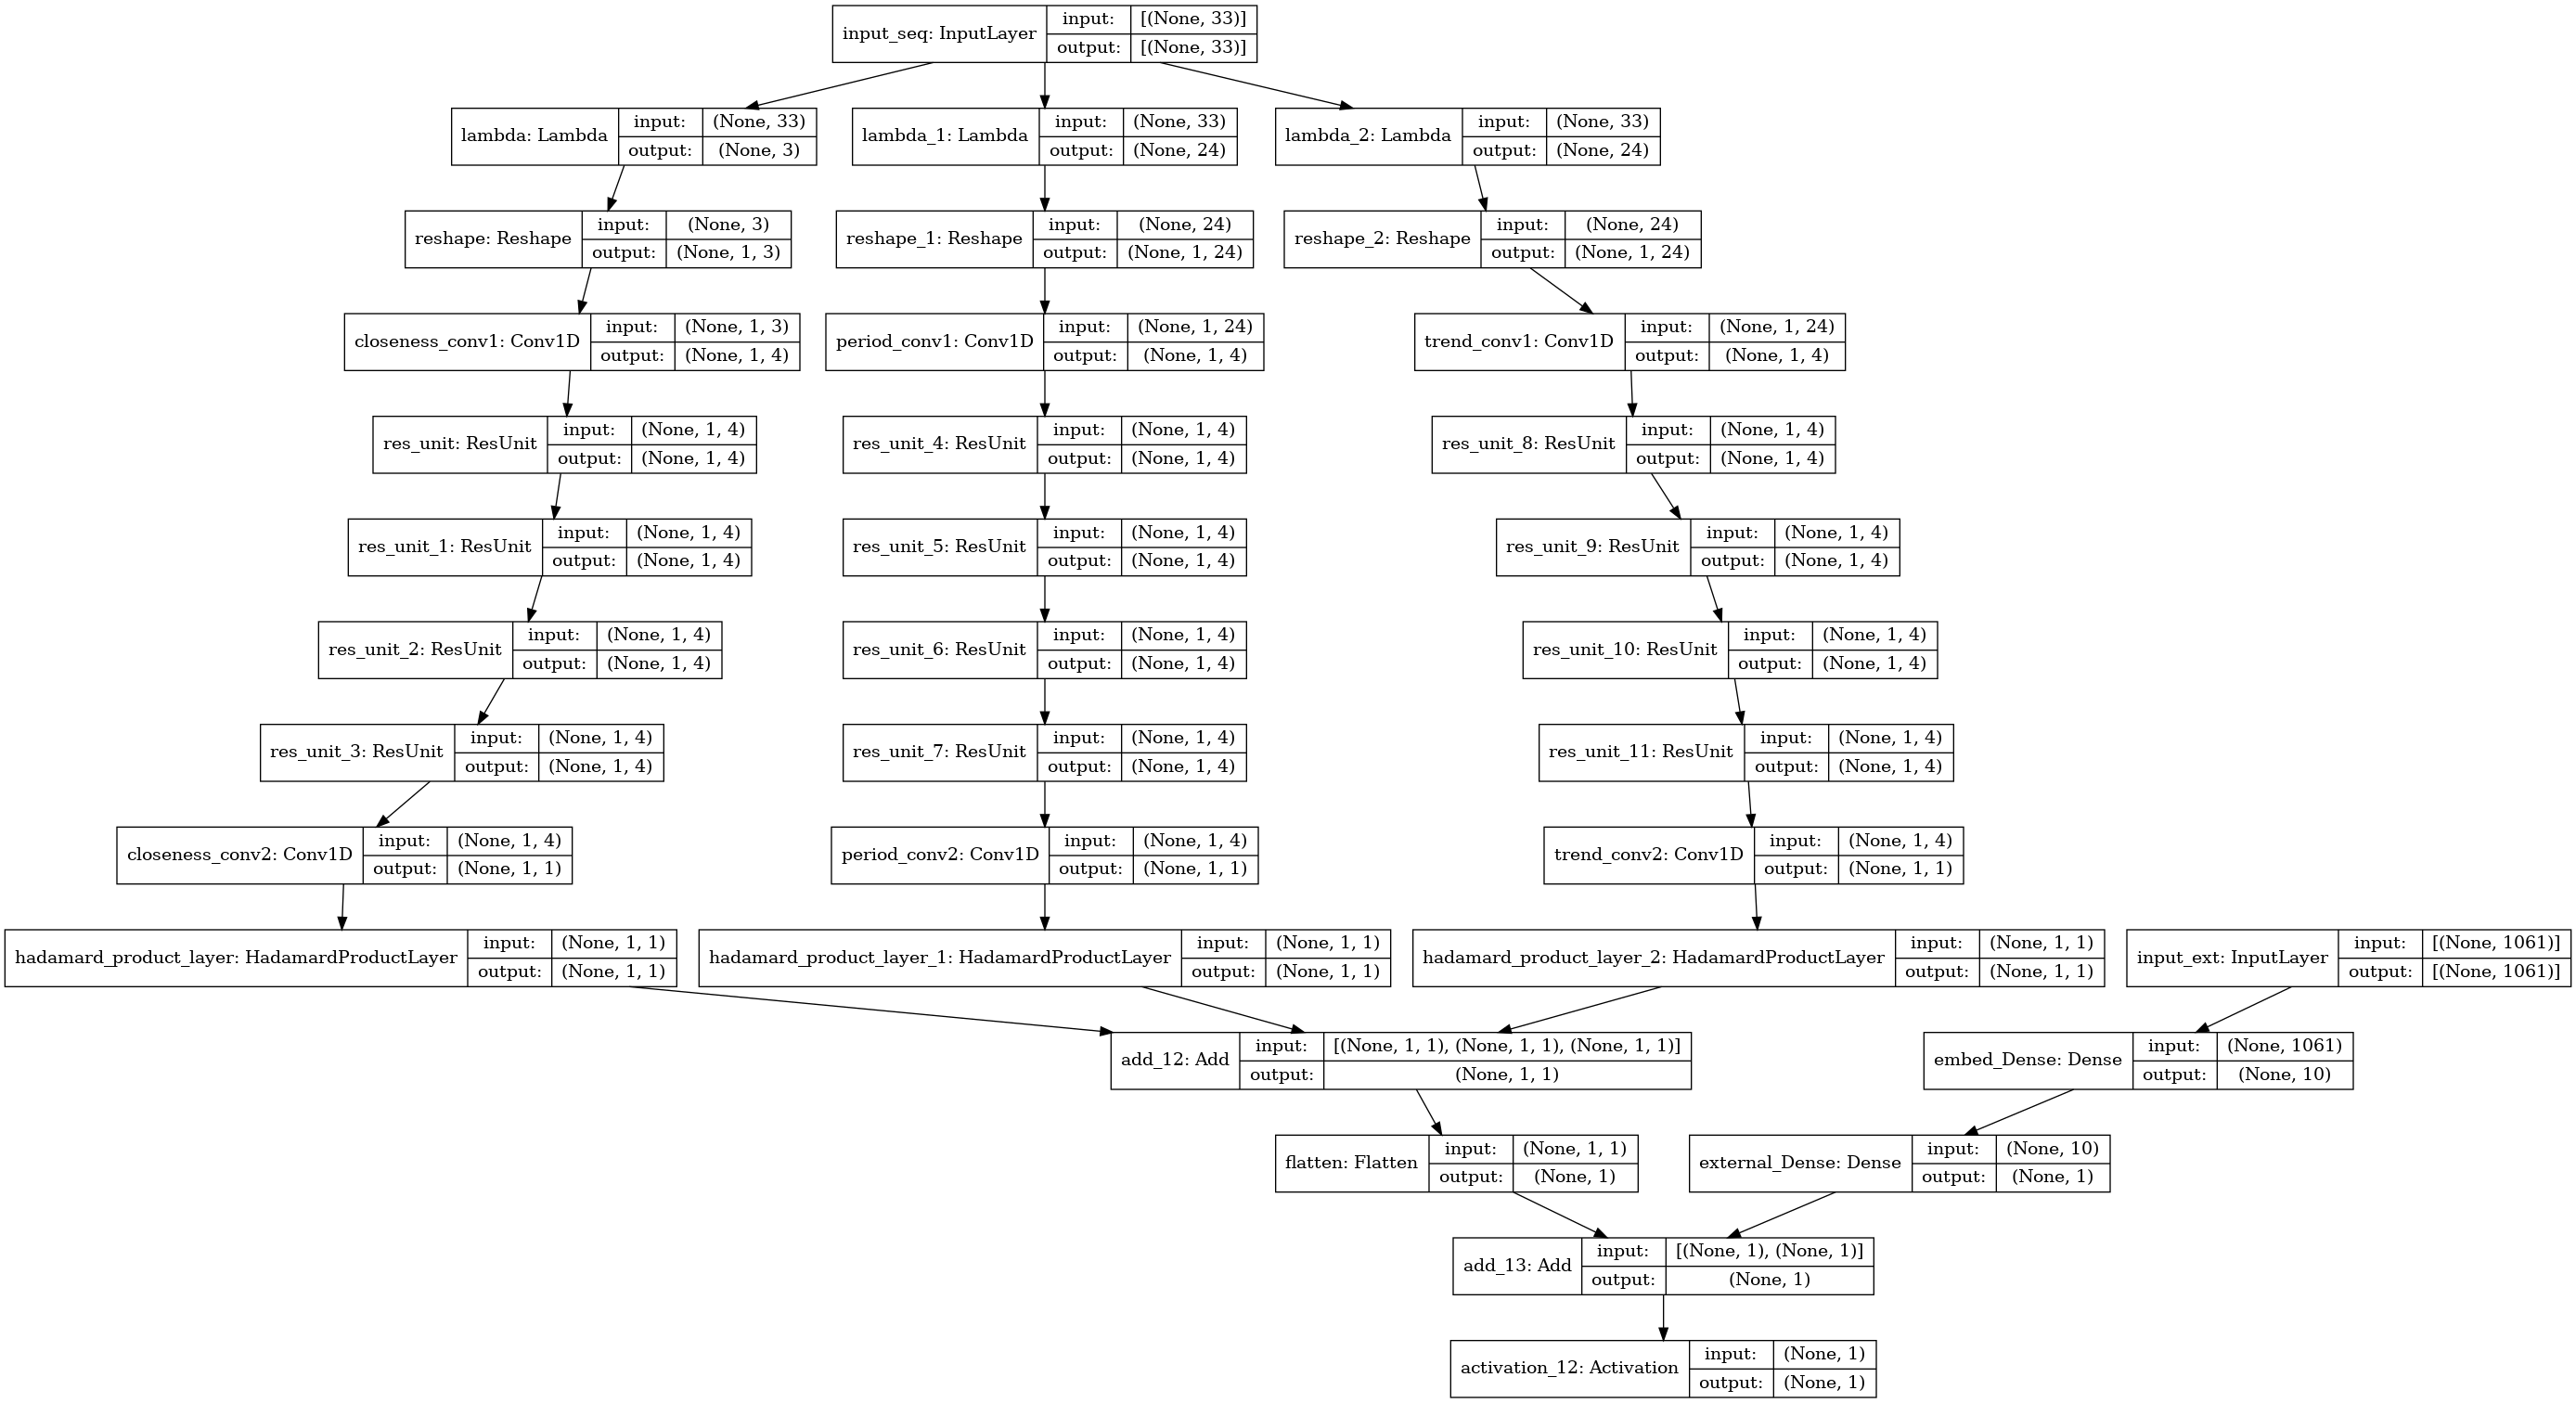

In [17]:
tf.keras.utils.plot_model(model, to_file='model_graph.png', show_shapes=True, show_layer_names=True)

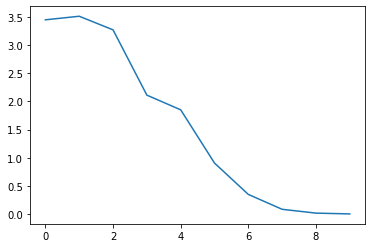

In [18]:
plt.plot(history.history['loss'])
plt.show()

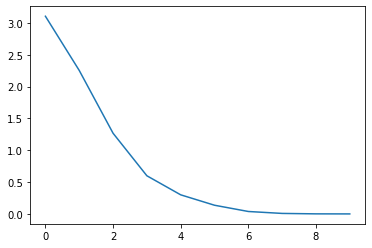

In [19]:
plt.plot(history.history['val_loss'])
plt.show()

In [20]:
# Prepare Test dataset

test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
test_df['shop_item'] = test_df['shop_id'].astype('string') + '-' + test_df['item_id'].astype('string')

X_test_ext = []
X_test_seq = []
for _, row in test_df.iterrows():
    shop_item = row['shop_item']
    shop_id = row['shop_id']
    item_id = row['item_id']
    
    # get sale_cnt_seq
    if shop_item in data_seq_dict.keys():
        sale_cnt_seq = data_seq_dict[shop_item][1:]
    elif item_id in item_seq_dict.keys():
        sale_cnt_seq = item_seq_dict[item_id][1:]
    else:
        sale_cnt_seq = [0.0 for i in range(0,STEPS)]
    
    # get price
    if shop_item in shopitem_price_dict.keys():
        price = shopitem_price_dict[shop_item]
    elif item_id in item_price_dict.keys():
        price = item_price_dict[item_id]
    else:
        price = 0.0
    
    # generate the sample
    shop_vec = int(shop_id)
    item_vec = int(item_id) % ITEM_VOCAB_LEN
    static_vec = feature_encoder.transform([[shop_vec, item_vec]]).toarray().reshape((-1,))  # array (EXT_DIM,)
    price_vec = price_scaler.transform([[price]]).reshape((-1,))  # array (1,)
    ext_vec = np.concatenate([static_vec, price_vec])  # array (EXT_DIM+1,)
    sale_cnt_seq = np.array([sale_cnt_scaler.scale(i) for i in sale_cnt_seq])
    X_test_ext.append(ext_vec)
    X_test_seq.append(sale_cnt_seq)
X_test_ext = np.array(X_test_ext)
X_test_seq = np.array(X_test_seq)

print('X_test_ext:')
print(X_test_ext)
print('X_test_seq:')
print(X_test_seq)

X_test_ext:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  2.43330807e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -2.92226853e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  3.89281885e-03]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  6.45853816e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  2.99727343e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.78229158e-03]]
X_test_seq:
[[-0.98065934 -0.98065934 -0.98065934 ... -0.97802198 -0.97978022
  -0.98065934]
 [-0.98065934 -0.98065934 -0.98065934 ... -0.98065934 -0.98065934
  -0.98065934]
 [-0.98065934 -0.98065934 -0.98065934 ... -0.97978022 -0.97802198
  -0.97978022]
 ...
 [-0.98065934 -0.98065934 -0.98065934 ... -0.98065934 -0.98065934
  -0.98065934]
 [-0.980659

In [21]:
pred = model.predict({'input_ext':X_test_ext, 'input_seq':X_test_seq})  # array, (214200, 1)

In [22]:
# recover the prediction (de-normalized)
result = np.squeeze(pred)  # array, (214200,)
descale_func = np.vectorize(sale_cnt_scaler.descale)
result = descale_func(result)
result[result<0.0] = 0.0

In [23]:
submission_df = pd.DataFrame(result, columns=['item_cnt_month'])
submission_df.index.name = 'ID'
submission_df

,item_cnt_month
ID,
0,18.169431
1,11.354282
2,15.163980
3,13.237096
4,15.445147
...,...
214195,13.619421
214196,13.269029
214197,8.400901


In [24]:
submission_df.to_csv('/kaggle/working/submission.csv')